In [1]:
import pandas as pd
import random
import time
import numpy as np
import polars as pl
#import keras
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from collections import Counter
#from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Functions

In [2]:
class TimeCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        epoch_begin = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print("{time} ---".format(time=epoch_begin),end=(""))

In [3]:
def get_data(filepath):
    data = pl.read_csv(filepath+"train.csv")


    # Split test and train based on unique sequence ids
    random.seed(time.time())
    sequence_ids = list(data['sequence_id'].unique())
    test_num = int(len(sequence_ids)*.2)
    train_ids = []
    test_ids = []
    for seq_id in random.sample(sequence_ids, len(sequence_ids)):
        if len(test_ids) <= test_num:
            test_ids.append(seq_id)
        else:
           train_ids.append(seq_id)

    return train_ids, test_ids, data

In [4]:
def pad_seq(seq, max_len):
  t = seq.shape[0]
  if t < max_len:
    #pad_width = ((0, max_len - t), (0, 0))  # pad along time axis only
    #return np.pad(seq, pad_width, mode='constant')
    pad_total = max_len - t
    pad_before = int(pad_total // 2)
    pad_after = int(pad_total - pad_before)

    padding_before = np.zeros((pad_before, seq.shape[1]))
    padding_after = np.zeros((pad_after, seq.shape[1]))

    return np.vstack([padding_before, seq, padding_after])
  else:
    start = (t - max_len) // 2
    end = start + max_len
    return seq[start:end] # truncate if longer

In [5]:
def score_model(y_pred, y_true, title = "Baseline DNN"):

  target_gestures = [
              'Above ear - pull hair',
              'Cheek - pinch skin',
              'Eyebrow - pull hair',
              'Eyelash - pull hair',
              'Forehead - pull hairline',
              'Forehead - scratch',
              'Neck - pinch skin',
              'Neck - scratch',
          ]

  non_target_gestures = [
              'Write name on leg',
              'Wave hello',
              'Glasses on/off',
              'Text on phone',
              'Write name in air',
              'Feel around in tray and pull out an object',
              'Scratch knee/leg skin',
              'Pull air toward your face',
              'Drink from bottle/cup',
              'Pinch knee/leg skin'
          ]

  # Convert from numbers to string
  gesture_uniq = data['gesture'].unique()

  sub = np.array([gesture_uniq[int(x)] for x in y_pred]).reshape(-1, 1)
  sol = np.array([gesture_uniq[int(x[0])] for x in y_true]).reshape(-1, 1)

  # Compute confusion matrix
  cm = confusion_matrix(sol, sub)

  # Plot using sklearn's ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues, include_values=False)
  plt.title(title + ": Confusion Matrix - gesture")
  plt.show()
  print("")

  y_true_bin = np.isin(sol, target_gestures)
  y_pred_bin = np.isin(sub, target_gestures)

   # Compute confusion matrix
  cm = confusion_matrix(y_true_bin, y_pred_bin)

  # Plot using sklearn's ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues, include_values=True)
  plt.title(title + ": Confusion Matrix - target vs non-target")
  plt.show()

  f1_binary = f1_score(
              y_true_bin,
              y_pred_bin,
              pos_label=True,
              zero_division=0,
              average='binary'
          )
  print("f1 binary: "+ str(f1_binary))

  # Build multi-class labels for gestures
  #y_true_mc = sol.apply(lambda x: x if x in target_gestures else 'non_target')
  y_true_mc = np.where(np.isin(sol, target_gestures), sol, 'non_target')
  #y_pred_mc = sub.apply(lambda x: x if x in target_gestures else 'non_target')
  y_pred_mc = np.where(np.isin(sol, target_gestures), sub, 'non_target')

  # Compute macro F1 over all gesture classes
  f1_macro = f1_score(
    y_true_mc,
    y_pred_mc,
    average='macro',
    zero_division=0
  )

  print("f1 macro: "+ str(f1_macro))

  score = 0.5 * f1_binary + 0.5 * f1_macro
  print("score: "+str(score))
  return score


#Preprocess Data

In [6]:

# Main
## Pull in & Preprocess Data
filepath = "C:/Users/trfit/OneDrive/Documents/learning/UC/cmi_project/cmi-detect-behavior-with-sensor-data/"
filepath = "/content/"
filepath = "/content/drive/MyDrive/cmi_data/"


train_features = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
for sensor_num in range(1,6): # sensor_num: 1-5, pix_num:, 0-63
        for pix_num in range(0,64):
            train_features.append('tof_'+str(sensor_num)+'_v'+str(pix_num))

# train_features = o_train_features + tof_train_features

print("Inital parameters defined. Start pulling data...")

train_ids, test_ids, data = get_data(filepath)

print("Data pulled. Start X data cleaning...")

# Remove null values
data = data.drop_nulls()

# Normalize data
train_features_norm = []
o_train_features_norm = []
tof_train_features_norm = []
for feature in train_features:
    train_features_norm.append(feature+"_norm")
    if 'tof_' in feature:
        data = data.with_columns(pl.col(feature).replace(-1, 256))
        data = data.with_columns((pl.col(feature)/253).alias(feature+"_norm"))
        tof_train_features_norm.append(feature+"_norm")
    else:
        data = data.with_columns(
            ((pl.col(feature)-pl.col(feature).min())/
             (pl.col(feature).max()-pl.col(feature).min())
            ).alias(feature+"_norm"))
        o_train_features_norm.append(feature+"_norm")

print("X data cleaned. Start y data reformating...")

target_params = {'_o': 'orientation',
                 '_b': 'behavior',
                 '_p': 'phase',
                 '_g': 'gesture',
                 '_s': 'sequence_type'}

for suffix, target_param in target_params.items():

  # Prep target data
  target_uniq = data[target_param].unique()
  data = data.with_columns(pl.col(target_param).replace(target_uniq, [x for x in range(len(target_uniq))]).cast(pl.Int8).alias("target"+suffix))


print("y data reformated.")

grouped_dict = {
    sid[0]: group
    for sid, group in data.group_by("sequence_id", maintain_order=True)
}

data_dic = {}

Inital parameters defined. Start pulling data...
Data pulled. Start X data cleaning...
X data cleaned. Start y data reformating...
y data reformated.


In [7]:
data_dic['X_train_non_tof'] = np.asarray(data.filter(pl.col("sequence_id").is_in(train_ids)).select(o_train_features_norm))

In [8]:
data_dic['X_train_non_tof'].shape

(427398, 12)

In [9]:
# Prepare X data for Stage 1
#data_dic['X_train_non_tof'] = np.asarray(data.filter(pl.col("sequence_id").is_in(train_ids)).select(o_train_features_norm))
#data_dic['X_test_non_tof'] = np.asarray(data.filter(pl.col("sequence_id").is_in(test_ids)).select(o_train_features_norm))

data_dic['X_train_tof'] = data.filter(pl.col("sequence_id").is_in(train_ids)).select(tof_train_features_norm) .to_numpy().reshape(-1, 8, 8, 5) # 5 sensors with 8x8 dist grid
data_dic['X_test_tof'] = data.filter(pl.col("sequence_id").is_in(test_ids)).select(tof_train_features_norm).to_numpy().reshape(-1, 8, 8,5)
#else:
data_dic['X_train'] = np.asarray(data.filter(pl.col("sequence_id").is_in(train_ids)).select(train_features_norm))
data_dic['X_test'] = np.asarray(data.filter(pl.col("sequence_id").is_in(test_ids)).select(train_features_norm))

In [10]:
# Prepare X data for Stage 2
data_dic['X_train_rnn'] = []
data_dic['X_test_rnn'] = []

for sid in train_ids:
  if sid in grouped_dict.keys():
    seq = grouped_dict[sid].select(train_features_norm).to_numpy()
    data_dic['X_train_rnn'].append(pad_seq(seq, 100))

for sid in test_ids:
  if sid in grouped_dict.keys():
    seq = grouped_dict[sid].select(train_features_norm).to_numpy()
    data_dic['X_test_rnn'].append(pad_seq(seq, 100))

data_dic['X_train_rnn'] = np.array(data_dic['X_train_rnn'])
data_dic['X_test_rnn'] = np.array(data_dic['X_test_rnn'])

In [11]:
# Prepare y data for Stage 1

for suffix, target_param in target_params.items():

  data_dic['y_train'+suffix] = np.asarray((data.filter(pl.col("sequence_id").is_in(train_ids)).select('target'+suffix)))
  data_dic['y_test'+suffix] = np.asarray((data.filter(pl.col("sequence_id").is_in(test_ids)).select('target'+suffix)))

In [12]:
grouped_dict_y = {'sid':[], 'target_s':[], 'target_g':[]}

for sid in grouped_dict.keys():
  grouped_dict_y['sid'].append(sid)
  grouped_dict_y['target_s'].append(grouped_dict[sid]['target_s'][0])
  grouped_dict_y['target_g'].append(grouped_dict[sid]['target_g'][0])

  if len(np.unique(grouped_dict[sid]['target_s'])) > 1:
    print(sid+' target_s is not unique')
  if len(np.unique(grouped_dict[sid]['target_s'])) > 1:
    print(sid+' target_s is not unique')
y_data = pl.DataFrame(grouped_dict_y)

data_dic['y_train_s'] = np.asarray((y_data.filter(pl.col("sid").is_in(train_ids)).select('target_s')))
data_dic['y_train_g'] = np.asarray((y_data.filter(pl.col("sid").is_in(train_ids)).select('target_g')))

data_dic['y_test_s'] = np.asarray((y_data.filter(pl.col("sid").is_in(test_ids)).select('target_s')))
data_dic['y_test_g'] = np.asarray((y_data.filter(pl.col("sid").is_in(test_ids)).select('target_g')))

# Models

In [13]:
model_info = {
        'epochs': 5,
        'learning_rate': 0.01,
        'loss':  keras.losses.SparseCategoricalCrossentropy(), # multiclass crossentropy
        "activation": 'relu',
        "final_activation": 'softmax',
}

comb_models = {}

## Stage 1: CNN -> DNN ->

### define CNN

In [14]:
model_cnn = keras.Sequential(
    [
        keras.Input(shape=(8, 8, 5)),
        keras.layers.Conv2D(8, kernel_size=(3, 3), activation=model_info['activation']),
        keras.layers.Conv2D(16, kernel_size=(3, 3), activation=model_info['activation']),
        keras.layers.Conv2D(8, kernel_size=(3, 3), activation=model_info['activation']),
        keras.layers.Flatten(),
        keras.layers.Dense(25, activation=model_info['final_activation']),
    ],
    name = 'cmi-CNN'
    )
comb_models['cnn'] = model_cnn

model_cnn.summary()

Model: "cmi-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 8)        │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

### define DNNs

In [15]:
model_o = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'cmi-orientation-DNN'
            )

model_b = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'cmi-behavior-DNN'
            )

model_p = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['activation']),
                keras.layers.Dense(2, activation=model_info['final_activation']),
            ],
            name = 'cmi-phase-DNN'
            )


comb_models['_o'] = model_o
comb_models['_b'] = model_b
comb_models['_p'] = model_p


In [16]:
for name, models in comb_models.items():
  print(name)
  print(models.summary())

cnn


Model: "cmi-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 8)        │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

None
_o


Model: "cmi-orientation-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916 (7.48 KB)

 Trainable params: 1,916 (7.48 KB)

 Non-trainable params: 0 (0.00 B)

None
_b


Model: "cmi-behavior-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916 (7.48 KB)

 Trainable params: 1,916 (7.48 KB)

 Non-trainable params: 0 (0.00 B)

None
_p


Model: "cmi-phase-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,926 (7.52 KB)

 Trainable params: 1,926 (7.52 KB)

 Non-trainable params: 0 (0.00 B)

None


### combine CNN & DNN

In [17]:
input_vector = keras.Input(shape=(332,))

# CNN model
cnn_input = keras.layers.Lambda(lambda x: x[:, 12:])(input_vector)
reshaped_cnn_input = keras.layers.Reshape((8, 8, 5))(cnn_input)
cnn_output = comb_models['cnn'](reshaped_cnn_input)

# DNN model
dnn_remain_input = keras.layers.Lambda(lambda x: x[:, :12])(input_vector)
dnn_input = keras.layers.Concatenate()([cnn_output, dnn_remain_input])

dnn_o_output = comb_models['_o'](dnn_input)
dnn_b_output = comb_models['_b'](dnn_input)
dnn_p_output = comb_models['_p'](dnn_input)

# link models together
cnn_dnn_model = keras.Model(inputs=input_vector, outputs=[dnn_o_output,dnn_b_output,dnn_p_output])
#cnn_dnn_b_model = keras.Model(inputs=input_vector, outputs=dnn_b_output)
#cnn_dnn_p_model = keras.Model(inputs=input_vector, outputs=dnn_p_output)

comb_models['cnn_dnn'] = cnn_dnn_model
#comb_models['cnn_dnn_b'] = cnn_dnn_b_model
#comb_models['cnn_dnn_p'] = cnn_dnn_p_model

In [18]:
comb_models['cnn_dnn'].summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 332)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 320)       │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 5)   │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-CNN             │ (None, 25)        │      3,521 │ reshape[0][0]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 12)        │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37)        │          0 │ cmi-CNN[0][0],    │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-orientation-DNN │ (None, 4)         │      1,916 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-behavior-DNN    │ (None, 4)         │      1,916 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-phase-DNN       │ (None, 2)         │      1,926 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,279 (36.25 KB)

 Trainable params: 9,279 (36.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# variation: make dnn_o an input to the other dnns
model_b = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'cmi-behavior-DNN'
            )

model_p = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['activation']),
                keras.layers.Dense(2, activation=model_info['final_activation']),
            ],
            name = 'cmi-phase-DNN'
            )


comb_models['_o'] = model_o
comb_models['_b'] = model_b
comb_models['_p'] = model_p

input_vector = keras.Input(shape=(332,))

# CNN model
cnn_input = keras.layers.Lambda(lambda x: x[:, 12:])(input_vector)
reshaped_cnn_input = keras.layers.Reshape((8, 8, 5))(cnn_input)
cnn_output = comb_models['cnn'](reshaped_cnn_input)

# DNN o model
dnn_remain_input = keras.layers.Lambda(lambda x: x[:, :12])(input_vector)
dnn_1_input = keras.layers.Concatenate()([cnn_output, dnn_remain_input])
dnn_o_output = comb_models['_o'](dnn_1_input)
dnn_p_output = comb_models['_p'](dnn_1_input)

# DNN models
dnn_2_input = keras.layers.Concatenate()([cnn_output, dnn_remain_input, dnn_o_output, dnn_p_output])
dnn_b_output = comb_models['_b'](dnn_2_input)

# link models together
cnn_dnn_o_model = keras.Model(inputs=input_vector, outputs=dnn_o_output)
cnn_dnn_b_model = keras.Model(inputs=input_vector, outputs=dnn_b_output)
cnn_dnn_p_model = keras.Model(inputs=input_vector, outputs=dnn_p_output)

comb_models['cnn_dnn_o'] = cnn_dnn_o_model
comb_models['cnn_dnn_b'] = cnn_dnn_b_model
comb_models['cnn_dnn_p'] = cnn_dnn_p_model


In [28]:

dnn_o_output.shape

(None, 4)

### run & evaluate Stage 1

In [80]:
hist = {}
eval = {}

for m in ["_o", "_b", "_p",
          "cnn",
          "cnn_dnn_o",
          "cnn_dnn_b",
          "cnn_dnn_p"]:
    comb_models[m].trainable = True

for suffix in ['_o','_b','_p']:

  start = datetime.now()
  comb_models['cnn_dnn'+suffix].compile(loss=model_info['loss'], optimizer="adam", metrics=["accuracy"])
  hist['cnn_dnn'+suffix] = comb_models['cnn_dnn'+suffix].fit(
      x = data_dic['X_train'], y = data_dic['y_train'+suffix],
      epochs=model_info['epochs'], callbacks=[TimeCallback()], validation_split=0.2,
      )

  stop = datetime.now()
  print("model Runtime: ", str(stop-start))

  print("Evaluate model")
  eval['cnn_dnn'+suffix] = str(round(comb_models['cnn_dnn'+suffix].evaluate(data_dic['X_test'], data_dic['y_test'+suffix], verbose=True)[1],4))
  print("Test accuracy: ", eval['cnn_dnn'+suffix])

2025-07-24 18:27:23 ---Epoch 1/5
10724/10724 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6747 - loss: 0.7910 - val_accuracy: 0.8592 - val_loss: 0.3975
2025-07-24 18:28:02 ---Epoch 2/5
10724/10724 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.8823 - loss: 0.3407 - val_accuracy: 0.8822 - val_loss: 0.3377
2025-07-24 18:28:39 ---Epoch 3/5
10724/10724 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9066 - loss: 0.2716 - val_accuracy: 0.8855 - val_loss: 0.3293
2025-07-24 18:29:16 ---Epoch 4/5
10724/10724 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9187 - loss: 0.2376 - val_accuracy: 0.9037 - val_loss: 0.2926
2025-07-24 18:29:54 ---Epoch 5/5
10724/10724 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9284 - loss: 0.2143 - val_accuracy: 0.8987 - val_loss: 0.3035
model Runtime:  0:03:12.108919
Evaluate model
3356/3356 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8981 - loss: 0.3018
Test accuracy:  0.9012
2025-07-24 18:30:41 ---Epoch 1/5
10724/10724 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step 

In [19]:
hist = {}
eval = {}

for m in ["_o", "_b", "_p",
          "cnn",
          #"cnn_dnn_o",
          #"cnn_dnn_b",
          "cnn_dnn"]:
    comb_models[m].trainable = True

for suffix in ['']:

  start = datetime.now()
  comb_models['cnn_dnn'+suffix].compile(loss=model_info['loss'], optimizer="adam", metrics=["accuracy", "accuracy", "accuracy"])
  hist['cnn_dnn'+suffix] = comb_models['cnn_dnn'+suffix].fit(
      x = data_dic['X_train'], y = [data_dic['y_train_o'], data_dic['y_train_b'], data_dic['y_train_p']],
      epochs=model_info['epochs'], callbacks=[TimeCallback()], validation_split=0.2,
      )

  stop = datetime.now()
  print("model Runtime: ", str(stop-start))

  print("Evaluate model")
  eval['cnn_dnn'+suffix] = str(round(comb_models['cnn_dnn'+suffix].evaluate(data_dic['X_test'], [data_dic['y_test_o'], data_dic['y_test_b'], data_dic['y_test_p']], verbose=True)[1],4))
  print("Test accuracy: ", eval['cnn_dnn'+suffix])

2025-07-26 02:04:30 ---Epoch 1/5
10685/10685 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - cmi-behavior-DNN_accuracy: 0.6176 - cmi-behavior-DNN_loss: 0.9627 - cmi-orientation-DNN_accuracy: 0.7151 - cmi-orientation-DNN_loss: 0.7169 - cmi-phase-DNN_accuracy: 0.7208 - cmi-phase-DNN_loss: 0.5199 - loss: 2.1995 - val_cmi-behavior-DNN_accuracy: 0.6348 - val_cmi-behavior-DNN_loss: 0.9009 - val_cmi-orientation-DNN_accuracy: 0.8758 - val_cmi-orientation-DNN_loss: 0.3577 - val_cmi-phase-DNN_accuracy: 0.7418 - val_cmi-phase-DNN_loss: 0.4942 - val_loss: 1.7531
2025-07-26 02:05:30 ---Epoch 2/5
10685/10685 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - cmi-behavior-DNN_accuracy: 0.6616 - cmi-behavior-DNN_loss: 0.8452 - cmi-orientation-DNN_accuracy: 0.9000 - cmi-orientation-DNN_loss: 0.2927 - cmi-phase-DNN_accuracy: 0.7586 - cmi-phase-DNN_loss: 0.4704 - loss: 1.6083 - val_cmi-behavior-DNN_accuracy: 0.6431 - val_cmi-behavior-DNN_loss: 0.8840 - val_cmi-orientation-DNN_accuracy: 0.8902 - val_cmi-orientation-DNN_loss: 0.3235

13404/13404 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


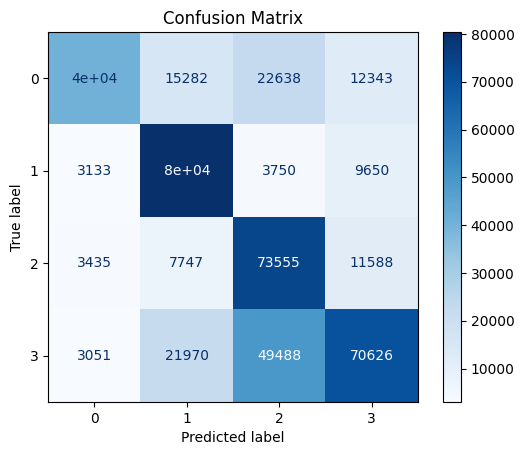

f1 binary: 0.7744404583195516
f1 macro: 0.48668337967228864
score: 0.6305619189959201
13404/13404 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step


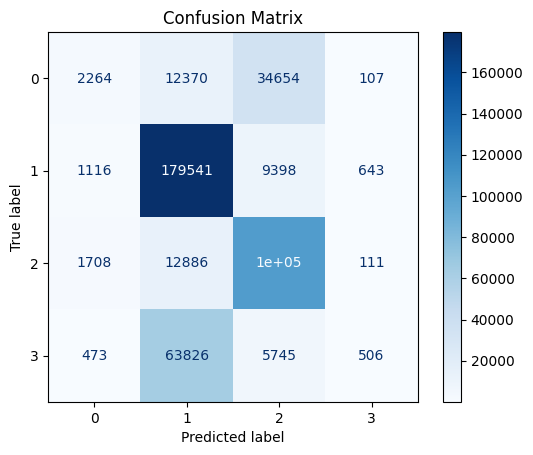

f1 binary: 0.9371918942819066
f1 macro: 0.538310851750726
score: 0.7377513730163163
13404/13404 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step


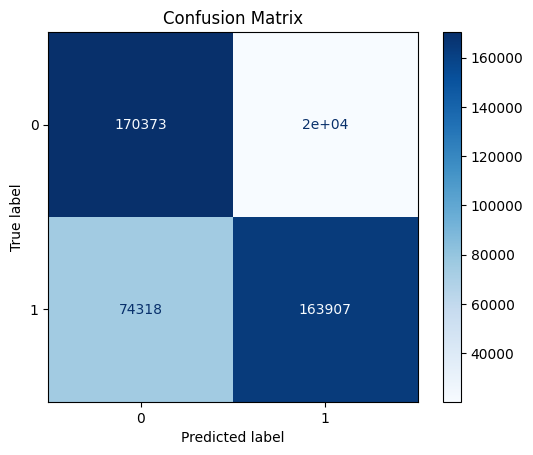

f1 binary: 0.775970098731942
f1 macro: 0.6050633457007484
score: 0.6905167222163452


In [82]:
suffix = "_g"
for suffix in ["_o", "_b", "_p"]:
  y_pred = np.argmax(comb_models['cnn_dnn'+suffix].predict(data_dic['X_train']), axis=1)


  # Example true and predicted labels
  y_true = data_dic['y_train'+suffix] #[0, 1, 2, 2, 0]
  #y_pred = [0, 0, 2, 2, 1]



  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Plot using sklearn's ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()

  score = score_model(y_pred, y_true)

### Evaluating the CNN part of the model

In [31]:
model_cnn.summary()

Model: "cmi-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 8)        │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

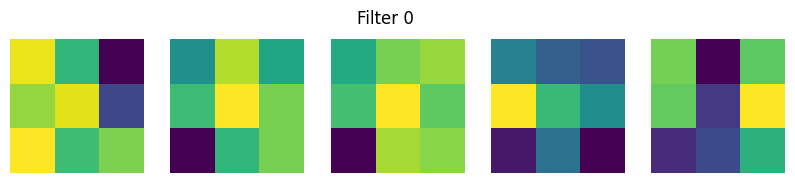

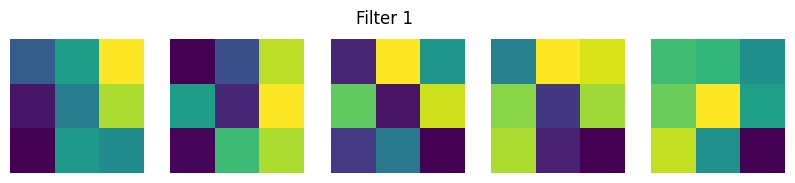

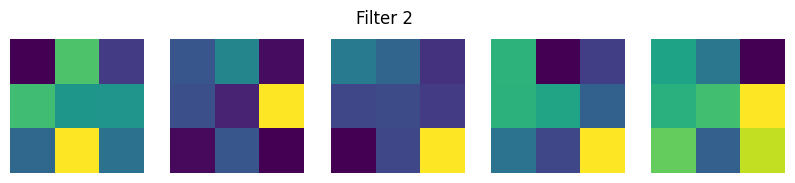

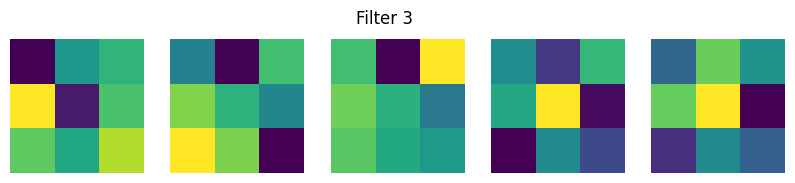

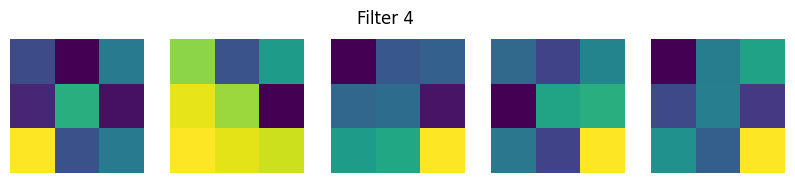

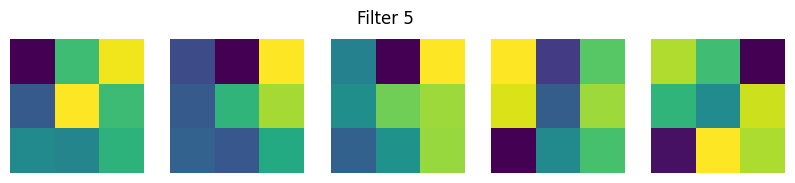

In [44]:
# Get the weights of the first convolutional layer
first_conv_layer = comb_models['cnn'].layers[0]  # or find by name or index
filters, biases = first_conv_layer.get_weights()

# Normalize filter values to 0-1 for visualization
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot filters
import matplotlib.pyplot as plt

n_filters = min(6, filters.shape[-1])  # visualize up to 6 filters
for i in range(n_filters):
    f = filters[:, :, :, i]  # shape: (H, W, in_channels)
    plt.figure(figsize=(10, 2))
    for j in range(f.shape[-1]):
        ax = plt.subplot(1, f.shape[-1], j + 1)
        plt.imshow(f[:, :, j], cmap="viridis")
        plt.axis("off")
    plt.suptitle(f"Filter {i}")
    plt.show()


In [40]:
#from tensorflow.keras.models import Model
#import numpy as np

# Define a new model to output intermediate activations
layer_outputs = [layer.output for layer in comb_models['cnn'].layers if 'conv' in layer.name]
activation_model = keras.Model(inputs=comb_models['cnn'].input, outputs=layer_outputs)

# Pick one input sample
sample_input = data_dic['X_test_tof'][0:1]  # shape should be (1, 5, 8, 8)

# Get activations
activations = activation_model.predict(sample_input)

# Plot first layer activations
first_layer_activation = activations[0]
n_features = first_layer_activation.shape[-1]

plt.figure(figsize=(15, 5))
for i in range(min(n_features, 6)):
    ax = plt.subplot(1, 6, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.title(f'Feature map {i}')
    plt.axis('off')
plt.suptitle("First Conv Layer Activations")
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'Reshape'

In [43]:
#from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Get the layers you want to visualize
# Assume `model` is your trained CNN+DNN model
layer_outputs = [layer.output for layer in comb_models['cnn_dnn'].layers if 'conv' in layer.name]

# Create a model that returns those activations
activation_model = keras.Model(inputs=comb_models['cnn_dnn'].input, outputs=layer_outputs)

# Run a forward pass with your input
sample_input = data_dic['X_test'][0:1]  # shape: (1, 8, 8, 5)
activations = activation_model.predict(sample_input)

# Visualize activations of the first conv layer
first_layer_activation = activations[0]  # shape: (1, H, W, num_filters)

n_filters = min(first_layer_activation.shape[-1], 6)  # Display up to 6 feature maps
plt.figure(figsize=(15, 5))
for i in range(n_filters):
    ax = plt.subplot(1, 6, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.title(f"Map {i}")
    plt.axis('off')
plt.suptitle("First Conv Layer Activations")
plt.show()


ValueError: `outputs` argument cannot be empty. Received:
inputs=<KerasTensor shape=(None, 332), dtype=float32, sparse=False, name=keras_tensor_22>
outputs=[]

### Indiviudal Runs

#### dnn_o

In [32]:
suffix = '_o'
comb_models['cnn_dnn'+suffix].trainable = True
start = datetime.now()
comb_models['cnn_dnn'+suffix].compile(loss=model_info['loss'], optimizer="adam", metrics=["accuracy"])
hist['cnn_dnn'+suffix] = comb_models['cnn_dnn'+suffix].fit(
    x = data_dic['X_train'], y = data_dic['y_train'+suffix],
    epochs=10, callbacks=[TimeCallback()], validation_split=0.2,
    )

stop = datetime.now()
print("model Runtime: ", str(stop-start))

print("Evaluate model")
eval['cnn_dnn'+suffix] = str(round(comb_models['cnn_dnn'+suffix].evaluate(data_dic['X_test'], data_dic['y_test'+suffix], verbose=True)[1],4))
print("Test accuracy: ", eval['cnn_dnn'+suffix])

2025-07-24 14:35:23 ---Epoch 1/10
10754/10754 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8328 - loss: 0.4899 - val_accuracy: 0.8935 - val_loss: 0.3201
2025-07-24 14:36:08 ---Epoch 2/10
 1199/10754 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9241 - loss: 0.2300

KeyboardInterrupt: 

In [ ]:
y_pred = np.argmax(comb_models['cnn_dnn'+suffix].predict(data_dic['X_test']), axis=1)

# Example true and predicted labels
y_true = data_dic['y_test'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### dnn_b

In [ ]:
model_b = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                #keras.layers.Dense(64, activation=model_info['activation']), # Added layer
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'cmi-behavior-DNN'
            )

In [ ]:
suffix = '_b'

# keras.optimizers.Adam(learning_rate=0.001)

comb_models['cnn_dnn'+suffix].trainable = True
start = datetime.now()

comb_models['cnn_dnn'+suffix].compile(
    loss=model_info['loss'],
    optimizer=keras.optimizers.Adam(),#learning_rate=0.0001), #"adam",
    metrics=["accuracy"])

hist['cnn_dnn'+suffix] = comb_models['cnn_dnn'+suffix].fit(
    x = data_dic['X_train'],
    y = data_dic['y_train'+suffix],
    epochs=5,
    callbacks=[TimeCallback()],
    validation_split=0.2,
    )

stop = datetime.now()
print("model Runtime: ", str(stop-start))

print("Evaluate model")
eval['cnn_dnn'+suffix] = str(round(comb_models['cnn_dnn'+suffix].evaluate(data_dic['X_test'], data_dic['y_test'+suffix], verbose=True)[1],4))
print("Test accuracy: ", eval['cnn_dnn'+suffix])



In [ ]:
y_pred = np.argmax(comb_models['cnn_dnn'+suffix].predict(data_dic['X_test']), axis=1)

# Example true and predicted labels
y_true = data_dic['y_test'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



- Baseline:
  - 10780/10780 ━ 29s 3ms/step - accuracy: 0.6791 - loss: 0.7898 - val_accuracy: 0.6477 - val_loss: 0.8855
  - model Runtime:  0:02:38.062602
  - Evaluate model
  - 3285/3285 ━━━ 7s 2ms/step - accuracy: 0.6625 - loss: 0.8567

- Change: Activation Function: Leaky Relu -> Not an improvement
  - 10780/10780 ━━━ 32s 3ms/step - accuracy: 0.6959 - loss: 0.7434 - val_accuracy: 0.6434 - val_loss: 0.8879
  - model Runtime:  0:05:29.439306
  - Evaluate model
  - 3285/3285 ━ 8s 2ms/step - accuracy: 0.6524 - loss: 0.8710
  - Test accuracy:  0.6478
  - Thoughts: Nope, change back

- Change: epochs 10 -> 5 (not for improvement, just to test changes faster)
- Change: learning rate 0.001 -> 0.01
  - 10780/10780 ━ 32s 3ms/step - accuracy: 0.6553 - loss: 0.8661 - val_accuracy: 0.6446 - val_loss: 0.8895
model
  - Runtime:  0:02:45.163904
  - Evaluate model
  - 3285/3285 ━━ 7s 2ms/step - accuracy: 0.6560 - loss: 0.8678
Test accuracy:  0.648
  - Thoughts: it may need more training?

- Change: epochs 5 -> 25, change learning rate to 0.0001
  - 2025-07-18 12:00:31 ---Epoch 25/25
10780/10780 ━━ 33s 3ms/step - accuracy: 0.6679 - loss: 0.8224 - val_accuracy: 0.6495 - val_loss: 0.8731
  - model Runtime:  0:13:19.958561
  - Evaluate model
  - 3285/3285 ━━━ 7s 2ms/step - accuracy: 0.6597 - loss: 0.8504
  - Test accuracy:  0.6532
  - Thoughts: this didnt help
- Change model: add a larger dense layer
  - didnt change much
- Change model: add dnn_o_output as an input.
  - 0 & 2 are the best classified, but 1 & 3 are struggling. I think it either needs to add temporal information (rate) or it needs to have the orientation data as an input.
  - 10668/10668 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.6843 - loss: 0.7748 - val_accuracy: 0.6474 - val_loss: 0.8712
  - model Runtime:  0:03:03.734368
  - Evaluate model
  - 3426/3426 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6618 - loss: 0.8448
  - Test accuracy:  0.6599
  - THoughts: add dnn_o upstream didnt really help

#### dnn_p

In [ ]:
model_p = keras.Sequential(
            [
                keras.Input(shape=(37,)),
                keras.layers.Dense(32, activation=model_info['activation']),
                keras.layers.Dense(16, activation=model_info['activation']),
                keras.layers.Dense(8, activation=model_info['activation']),
                keras.layers.Dense(4, activation=model_info['final_activation']),
            ],
            name = 'cmi-behavior-DNN'
            )

In [ ]:

suffix = '_p'
comb_models['cnn_dnn'+suffix].trainable = True
start = datetime.now()
comb_models['cnn_dnn'+suffix].compile(loss=model_info['loss'], optimizer="adam", metrics=["accuracy"])
hist['cnn_dnn'+suffix] = comb_models['cnn_dnn'+suffix].fit(
    x = data_dic['X_train'], y = data_dic['y_train'+suffix],
    epochs=5, callbacks=[TimeCallback()], validation_split=0.2,
    )

stop = datetime.now()
print("model Runtime: ", str(stop-start))

print("Evaluate model")
eval['cnn_dnn'+suffix] = str(round(comb_models['cnn_dnn'+suffix].evaluate(data_dic['X_test'], data_dic['y_test'+suffix], verbose=True)[1],4))
print("Test accuracy: ", eval['cnn_dnn'+suffix])

In [ ]:
y_pred = np.argmax(comb_models['cnn_dnn'+suffix].predict(data_dic['X_test']), axis=1)

# Example true and predicted labels
y_true = data_dic['y_test'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Stage 2: S1 -> RNN ->

In [20]:
model_s = keras.Sequential([
    keras.layers.Input(shape=(100, 47)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(2, activation='softmax')
],name = 'cmi-sequence_type-LSTM')

comb_models['rnn_s'] = model_s

model_g = keras.Sequential([
    keras.layers.Input(shape=(100, 47)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(18, activation='softmax')
],name = 'cmi-gesture-LSTM')

model_g = keras.Sequential([
    keras.layers.Input(shape=(100, 47)),
    #keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(128, dropout=0.3, return_sequences=True),
    keras.layers.LSTM(64, dropout=0.3), #, return_sequences=True),
    #keras.layers.LSTM(32),
    keras.layers.Dense(18, activation='softmax')  # Or softmax, depending on task
])

comb_models['rnn_g'] = model_g

In [21]:
for m in ["_o", "_b", "_p",
          "cnn",
          "cnn_dnn",
          #"cnn_dnn_b",
          #"cnn_dnn_p"
          ]:
    comb_models[m].trainable = False

input_vector = keras.Input(shape=(100, 332,))

# CNN model
cnn_input = keras.layers.Lambda(lambda x: x[:, :, 12:])(input_vector)
reshaped_cnn_input = keras.layers.Reshape((100, 8, 8, 5))(cnn_input)
cnn_output = keras.layers.TimeDistributed(comb_models['cnn'])(reshaped_cnn_input)

# DNN model
dnn_remain_input = keras.layers.Lambda(lambda x: x[:, :, :12])(input_vector)
dnn_input = keras.layers.Concatenate()([cnn_output, dnn_remain_input])

dnn_o_output = keras.layers.TimeDistributed(comb_models['_o'])(dnn_input)
dnn_b_output = keras.layers.TimeDistributed(comb_models['_b'])(dnn_input)
dnn_p_output = keras.layers.TimeDistributed(comb_models['_p'])(dnn_input)

# RNN model
rnn_input = keras.layers.Concatenate()([
    cnn_output,
    dnn_remain_input,
    dnn_o_output,
    dnn_b_output,
    dnn_p_output
    ])

rnn_output_s = comb_models['rnn_s'](rnn_input)
rnn_s_model = keras.Model(inputs=input_vector, outputs=rnn_output_s)

rnn_output_g = comb_models['rnn_g'](rnn_input)
rnn_g_model = keras.Model(inputs=input_vector, outputs=rnn_output_g)

comb_models['rnn_s'] = rnn_s_model
comb_models['rnn_g'] = rnn_g_model

In [22]:
for suffix in ["_g"]:
  start = datetime.now()
  comb_models['rnn'+suffix].compile(loss=model_info['loss'], optimizer="adam", metrics=["accuracy"])
  hist['rnn'+suffix] = comb_models['rnn'+suffix].fit(
      x = data_dic['X_train_rnn'], y = data_dic['y_train'+suffix],
      epochs=5#model_info['epochs']
      , callbacks=[TimeCallback()], validation_split=0.2,
      )

  stop = datetime.now()
  print("model Runtime: ", str(stop-start))

  print("Evaluate model")
  eval['rnn'+suffix] = str(round(comb_models['rnn'+suffix].evaluate(data_dic['X_test_rnn'], data_dic['y_test'+suffix], verbose=True)[1],4))
  print("Test accuracy: ", eval['rnn'+suffix])

2025-07-26 02:08:48 ---Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 71s 172ms/step - accuracy: 0.0820 - loss: 2.8126 - val_accuracy: 0.0865 - val_loss: 2.7998
2025-07-26 02:10:00 ---Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.0736 - loss: 2.7755 - val_accuracy: 0.0601 - val_loss: 2.7993
2025-07-26 02:10:11 ---Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.0714 - loss: 2.7707 - val_accuracy: 0.0783 - val_loss: 2.7936
2025-07-26 02:10:22 ---Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.0819 - loss: 2.7614 - val_accuracy: 0.0626 - val_loss: 2.7937
2025-07-26 02:10:33 ---Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.0878 - loss: 2.7561 - val_accuracy: 0.0799 - val_loss: 2.7832
model Runtime:  0:01:57.401832
Evaluate model
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.0624 - loss: 2.7771
Test accuracy:  0.0747


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


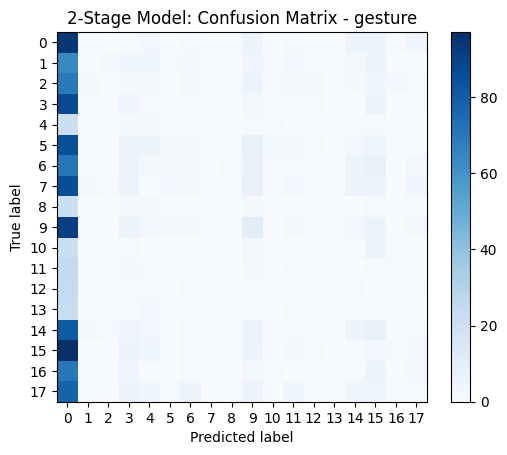

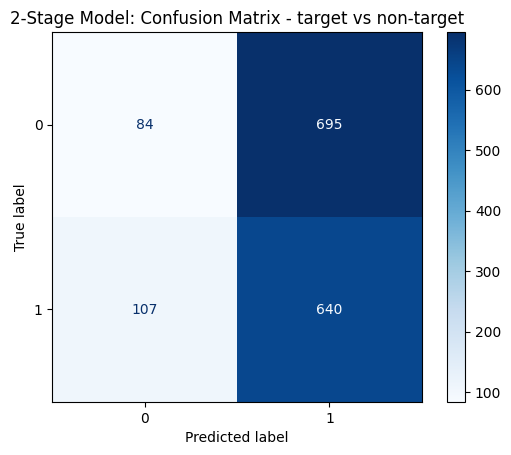

f1 binary: 0.6147934678194045
f1 macro: 0.0882525681516541
score: 0.35152301798552926


In [25]:
y_pred = np.argmax(model_g.predict(data_dic['X_test_rnn']), axis=1)

# Example true and predicted labels
y_true = data_dic['y_test'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]

score = score_model(y_pred, y_true, title="2-Stage Model")

In [24]:
for name, models in comb_models.items():
  print(name)
  print(models.summary())

cnn


Model: "cmi-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 8)        │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,521 (13.75 KB)

None
_o


Model: "cmi-orientation-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916 (7.48 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,916 (7.48 KB)

None
_b


Model: "cmi-behavior-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,916 (7.48 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,916 (7.48 KB)

None
_p


Model: "cmi-phase-DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,926 (7.52 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,926 (7.52 KB)

None
cnn_dnn


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 332)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 320)       │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 5)   │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-CNN             │ (None, 25)        │      3,521 │ reshape[0][0]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 12)        │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37)        │          0 │ cmi-CNN[0][0],    │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-orientation-DNN │ (None, 4)         │      1,916 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-behavior-DNN    │ (None, 4)         │      1,916 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-phase-DNN       │ (None, 2)         │      1,926 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,839 (108.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,279 (36.25 KB)

 Optimizer params: 18,560 (72.50 KB)

None
rnn_s


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100, 332)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 100, 320)  │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 100, 8, 8, │          0 │ lambda_2[0][0]    │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 100, 25)   │      3,521 │ reshape_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 100, 12)   │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 37)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 100, 4)    │      1,916 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 100, 4)    │      1,916 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 100, 2)    │      1,926 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100, 47)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ lambda_3[0][0],   │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmi-sequence_type-… │ (None, 2)         │    177,026 │ concatenate_2[0]… │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 186,305 (727.75 KB)

 Trainable params: 177,026 (691.51 KB)

 Non-trainable params: 9,279 (36.25 KB)

None
rnn_g


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100, 332)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 100, 320)  │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 100, 8, 8, │          0 │ lambda_2[0][0]    │
│                     │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 100, 25)   │      3,521 │ reshape_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 100, 12)   │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 37)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 100, 4)    │      1,916 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 100, 4)    │      1,916 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 100, 2)    │      1,926 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100, 47)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ lambda_3[0][0],   │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 18)        │    140,690 │ concatenate_2[0]… │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 431,351 (1.65 MB)

 Trainable params: 140,690 (549.57 KB)

 Non-trainable params: 9,279 (36.25 KB)

 Optimizer params: 281,382 (1.07 MB)

None


In [ ]:
for n in [0,200,30,67]:
  sample = rnn_input[n]  # shape: (timesteps, features)

  for i in range(min(64, sample.shape[1])):  # plot first 5 features
      i = i+12
      plt.plot(sample[:, i])#, label=f'Feature {i}')
  plt.title("Sample Sequence Over Time")
  plt.legend()
  plt.show()

In [ ]:
suffix = "_g"
y_pred = np.argmax(comb_models['rnn'+suffix].predict(data_dic['X_train_rnn']), axis=1)


# Example true and predicted labels
y_true = data_dic['y_train'+suffix] #[0, 1, 2, 2, 0]
#y_pred = [0, 0, 2, 2, 1]



# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

score = score_model(y_pred, y_true)

### Visualize rnn_input

In [66]:
# Get cnn outputs
cnn_out = comb_models['cnn'].predict(data_dic['X_train_tof'])

# Get dnn outputs
dnn_out = comb_models['cnn_dnn'].predict(data_dic['X_train'])
dnn_out_o = np.argmax(dnn_out[0], axis=1)/3
dnn_out_b = np.argmax(dnn_out[1], axis=1)/3
dnn_out_p = np.argmax(dnn_out[2], axis=1)

# Get 12 input sensors



13384/13384 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
13384/13384 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


In [89]:
dnn_out_o = dnn_out_o.reshape(-1, 1) #np.argmax(dnn_out[0], axis=1)/3
dnn_out_b = dnn_out_b.reshape(-1, 1) #np.argmax(dnn_out[1], axis=1)/3
dnn_out_p = dnn_out_p.reshape(-1, 1)

In [85]:
cnn_out

array([[0.043693  , 0.02221468, 0.03654763, ..., 0.06680016, 0.03707518,
        0.04453568],
       [0.06945661, 0.01943045, 0.04216083, ..., 0.07223126, 0.01447274,
        0.04185992],
       [0.01154288, 0.1160121 , 0.01243164, ..., 0.18948373, 0.10382533,
        0.01275448],
       ...,
       [0.064031  , 0.00442117, 0.06910302, ..., 0.004739  , 0.00288352,
        0.0163633 ],
       [0.04500091, 0.01223366, 0.05519063, ..., 0.00596805, 0.00583239,
        0.00782134],
       [0.06386743, 0.00676952, 0.05665844, ..., 0.00776268, 0.01087825,
        0.01118739]], dtype=float32)

In [128]:
rnn_in = np.hstack([cnn_out, dnn_out_o, dnn_out_b, dnn_out_p, data_dic['X_train_non_tof']])

In [101]:
for counts in [dnn_out[0], dnn_out_o, dnn_out_b, dnn_out_p]:
  print(
          f"Group sizes vary:\n"
          f"  min  = {counts.min()}\n"
          f"  max  = {counts.max()}\n"
          f"  med  = {np.median(counts)}\n"
          f"  mean = {counts.mean():.1f} ± {counts.std():.1f}"
      )

Group sizes vary:
  min  = 6.437401165342623e-16
  max  = 1.0
  med  = 0.004035733640193939
  mean = 0.2 ± 0.4
Group sizes vary:
  min  = 0.0
  max  = 1.0
  med  = 0.6666666666666666
  mean = 0.6 ± 0.4
Group sizes vary:
  min  = 0.0
  max  = 1.0
  med  = 0.6666666666666666
  mean = 0.8 ± 0.2
Group sizes vary:
  min  = 0
  max  = 1
  med  = 0.0
  mean = 0.4 ± 0.5


In [122]:
data_dic["X_train_non_tof"].shape

(108031, 12)

In [123]:
sample.shape

(428274, 28)

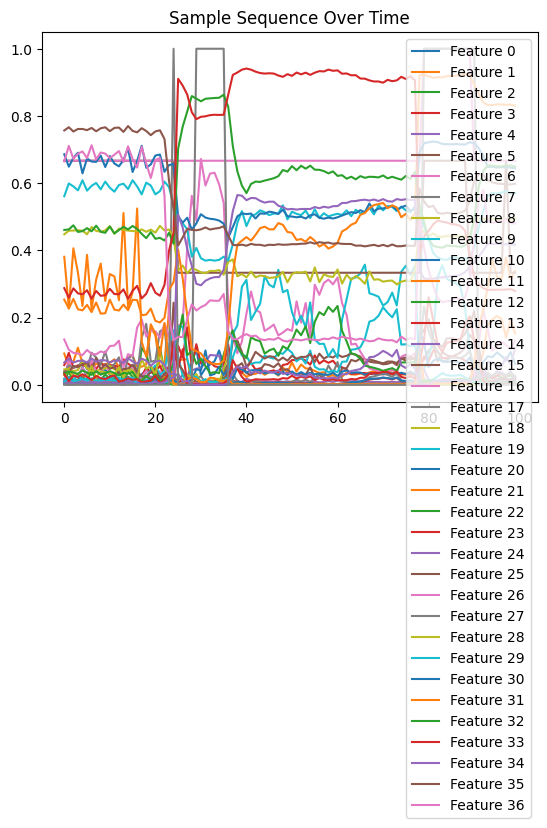

In [131]:
sample = rnn_in  # shape: (timesteps, features)

for i in range(min(37, sample.shape[1])):  # plot first 5 features

    plt.plot(sample[100:200, i], label=f'Feature {i}')
plt.title("Sample Sequence Over Time")
plt.legend()
plt.show()

# Improvement Plan

Stage 1:
- epochs
  - baseline: 5
  - orientation: 10
- learning rates
  - baseline: 0.001
- loss
  - baseline: SparseCategoricalCrossentropy
- activation
  - baseline: relu
  - test:keras.layers.LeakyReLU(negative_slope=0.3, **kwargs)
- final activation
  - baseline: softmax
- optimizer
  - baseline: Adam

Stage 2:



| change | baseline | cnn | dnn_o | dnn_b | dnn_p | rnn_s | rnn_g |
|--------|----------|-----|-------|-------|-------|-------|-------|
| epoch  |    5     |  na |  10   |   ni  |   ni  |   na  |   na  |


# Plots

In [ ]:
import polars as pl
import matplotlib.pyplot as plt

def plot_features_for_sequence(pl_df, seq_id_value, feature_names, sequence_id_col='sequence_id', title='Feature Trends for One Sequence'):
    """
    Plots multiple features for a specific sequence ID.

    Parameters:
    - pl_df: Polars DataFrame
    - seq_id_value: the value of the sequence ID to filter on (e.g., 'SEQ_000007')
    - feature_names: list of features to plot
    - sequence_id_col: name of the sequence ID column (default: 'seq_id')
    - title: title of the plot
    """
    # Filter for just one sequence ID
    df_seq = (
        pl_df
        .filter(pl.col(sequence_id_col) == seq_id_value)
        .select(feature_names)
        .to_pandas()
    )

    # Plot
    plt.figure(figsize=(12, 6))
    for feature in feature_names:
        plt.plot(df_seq[feature], label=feature)

    plt.title(f"{title}: {seq_id_value}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature Value")
    plt.legend(title="Features")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


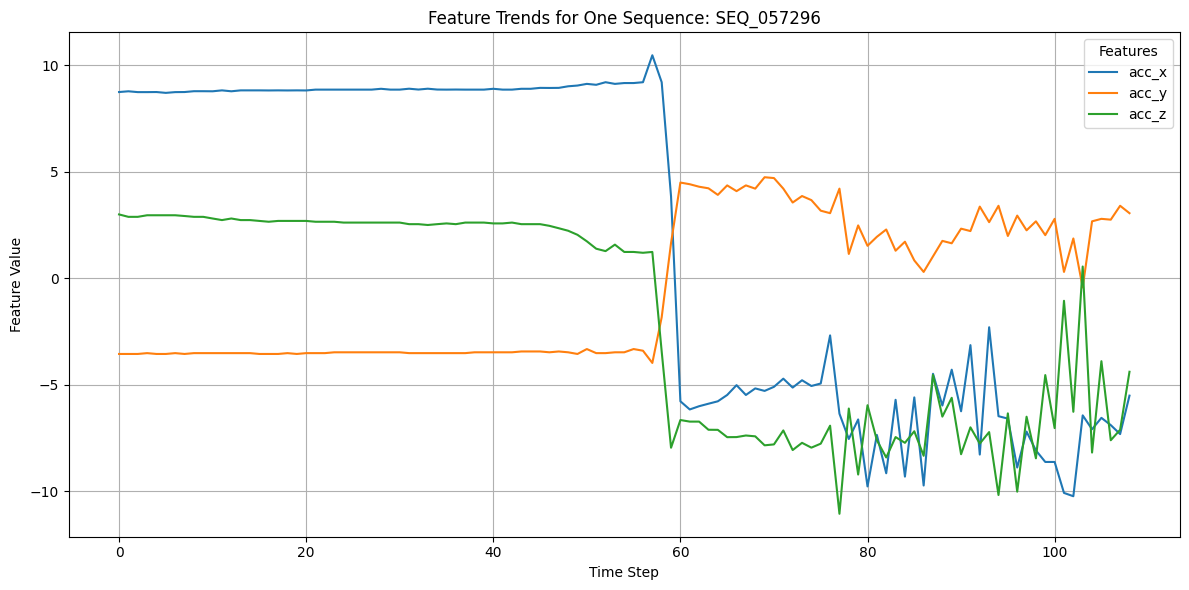

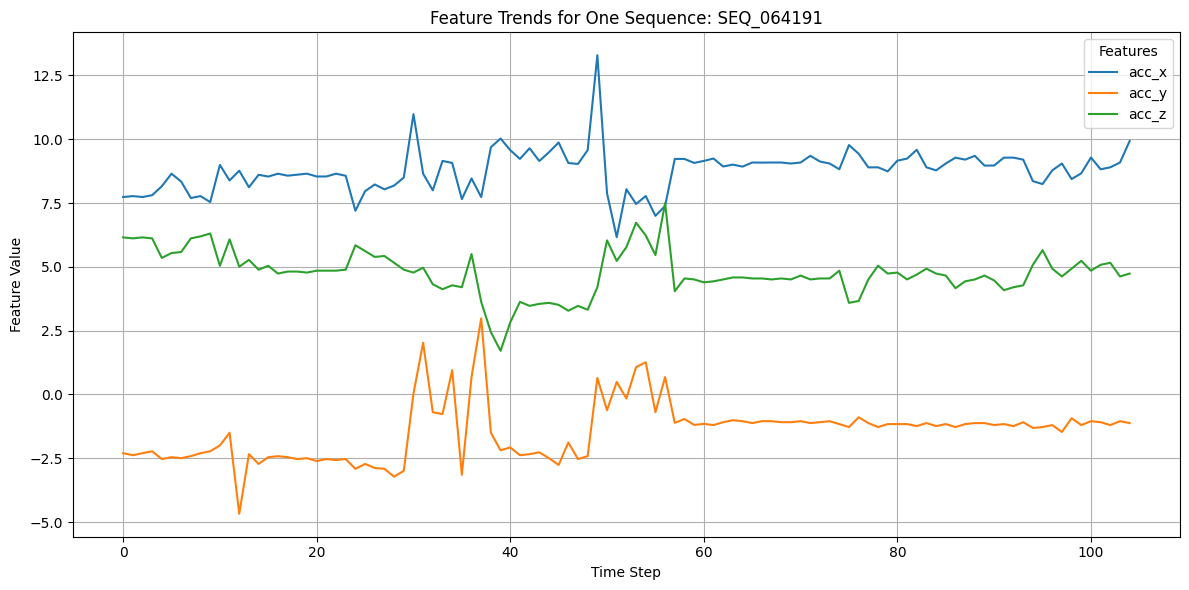

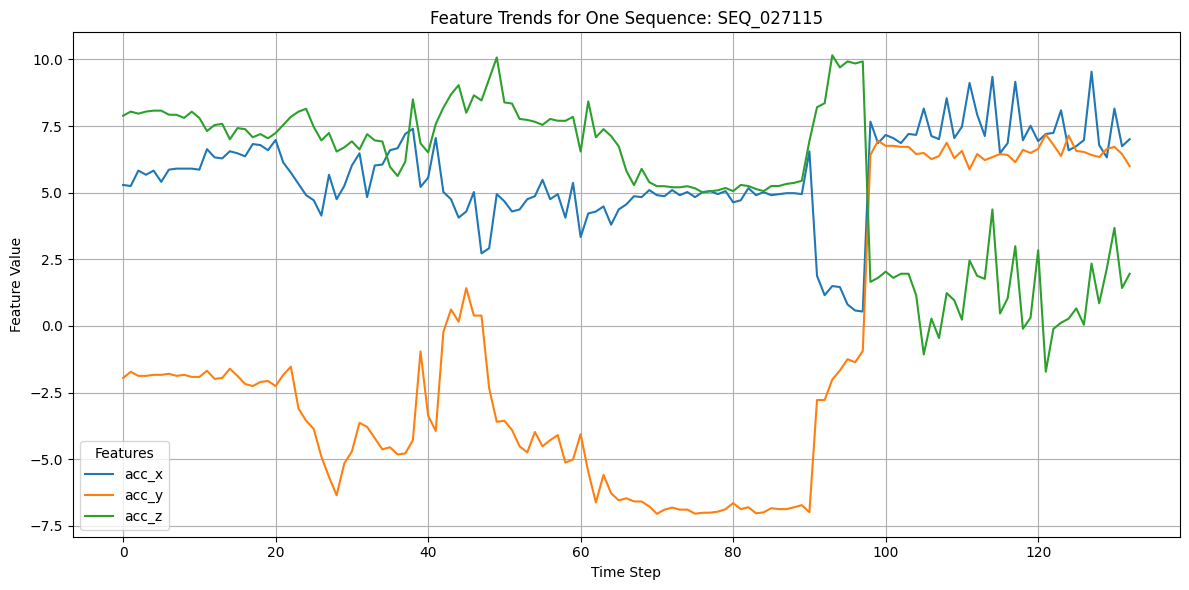

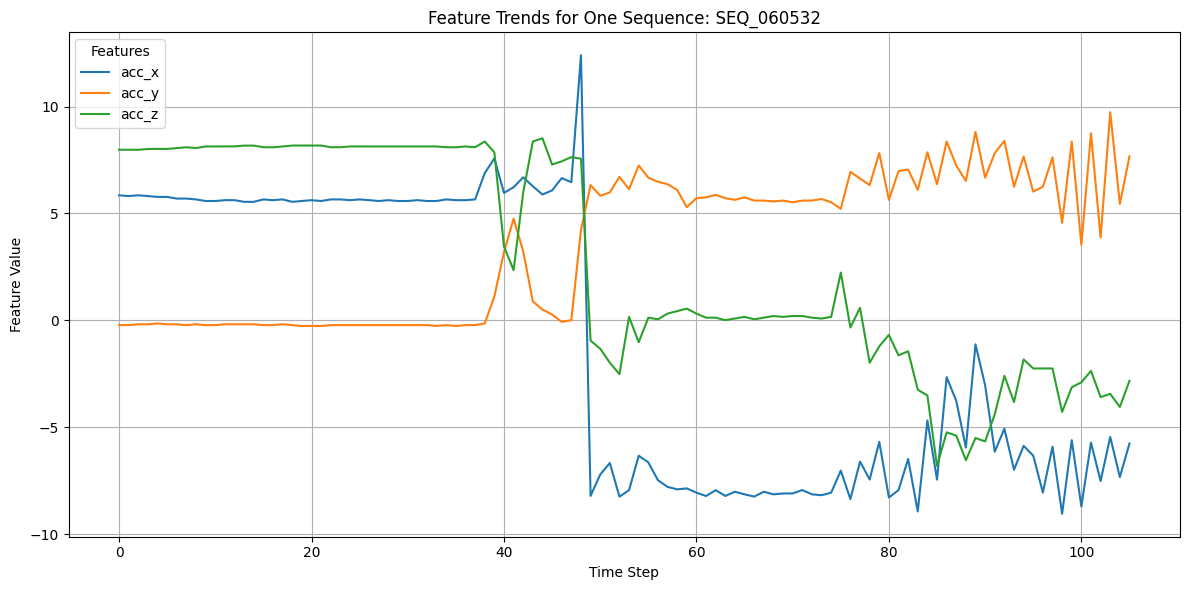

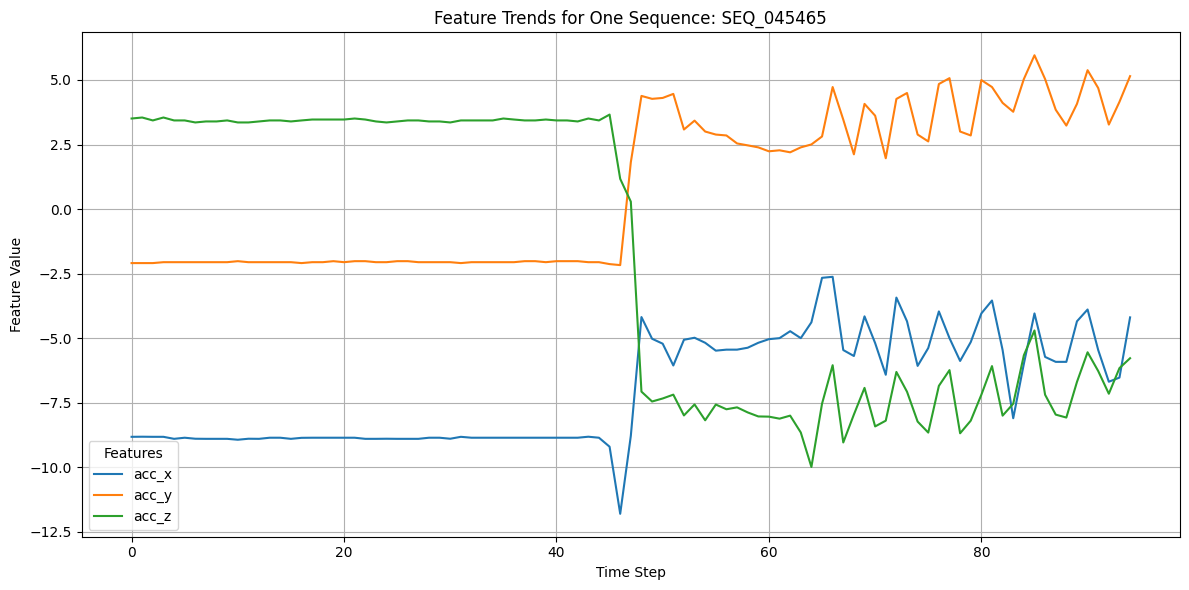

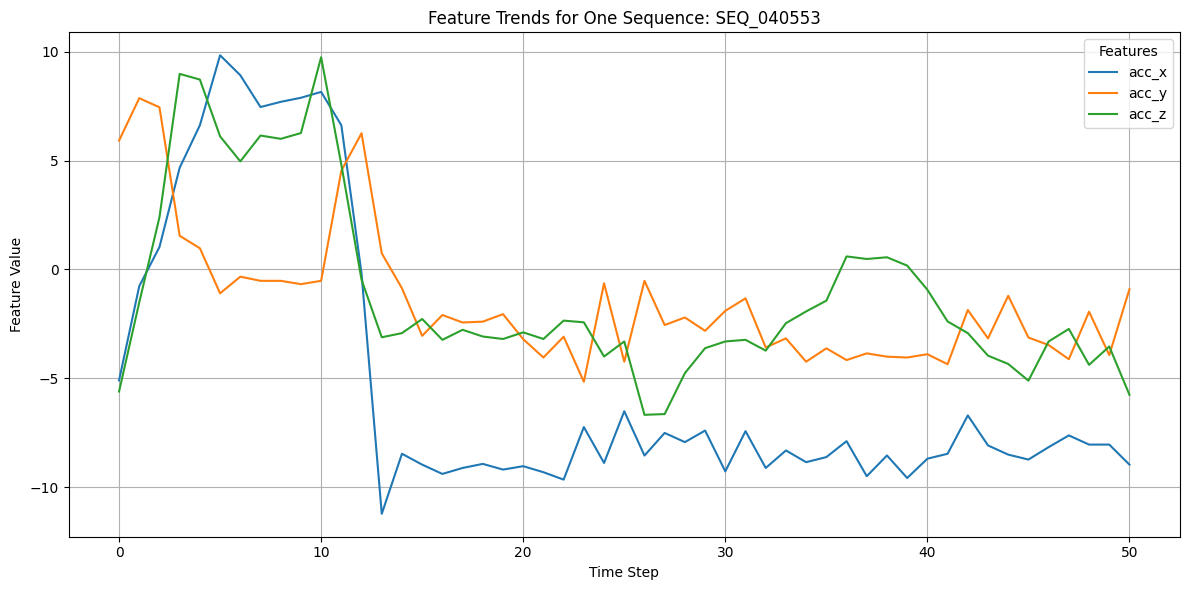

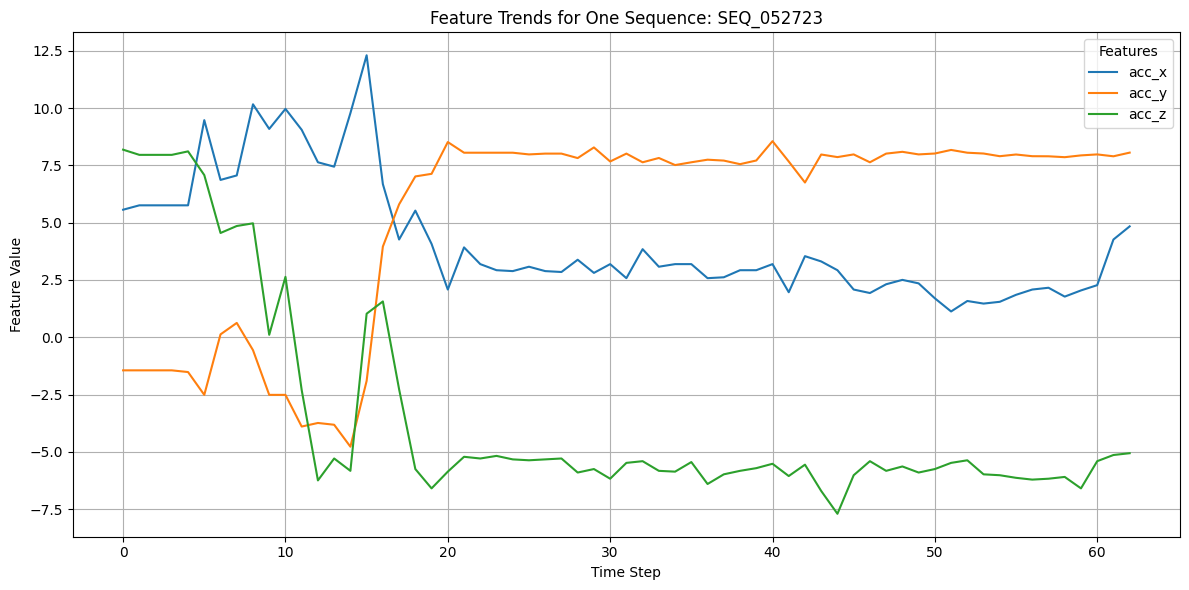

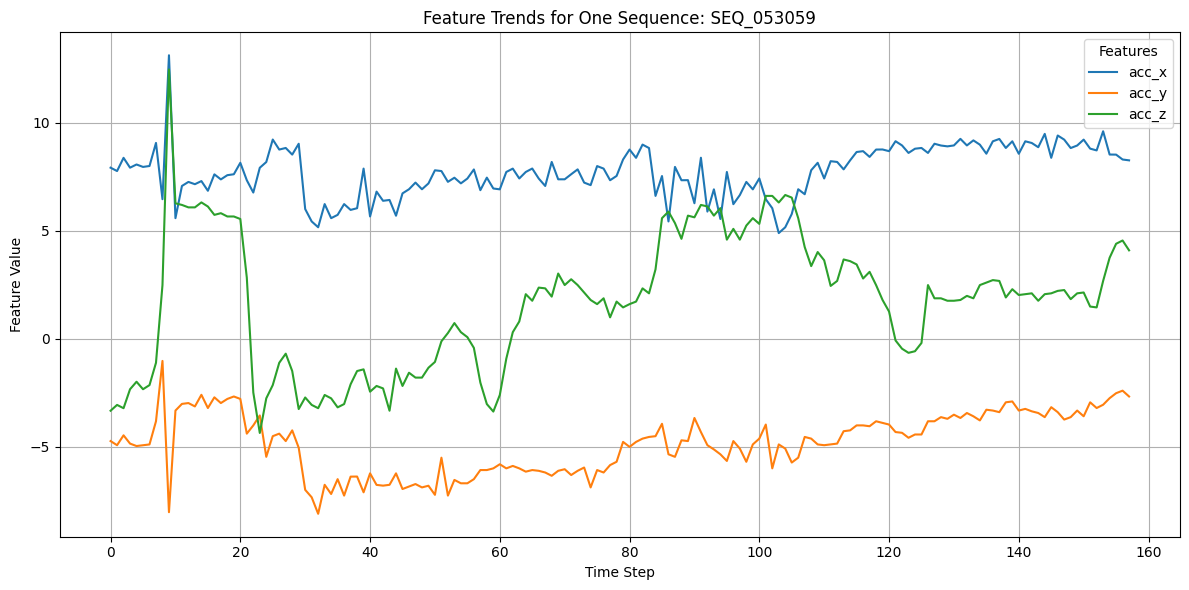

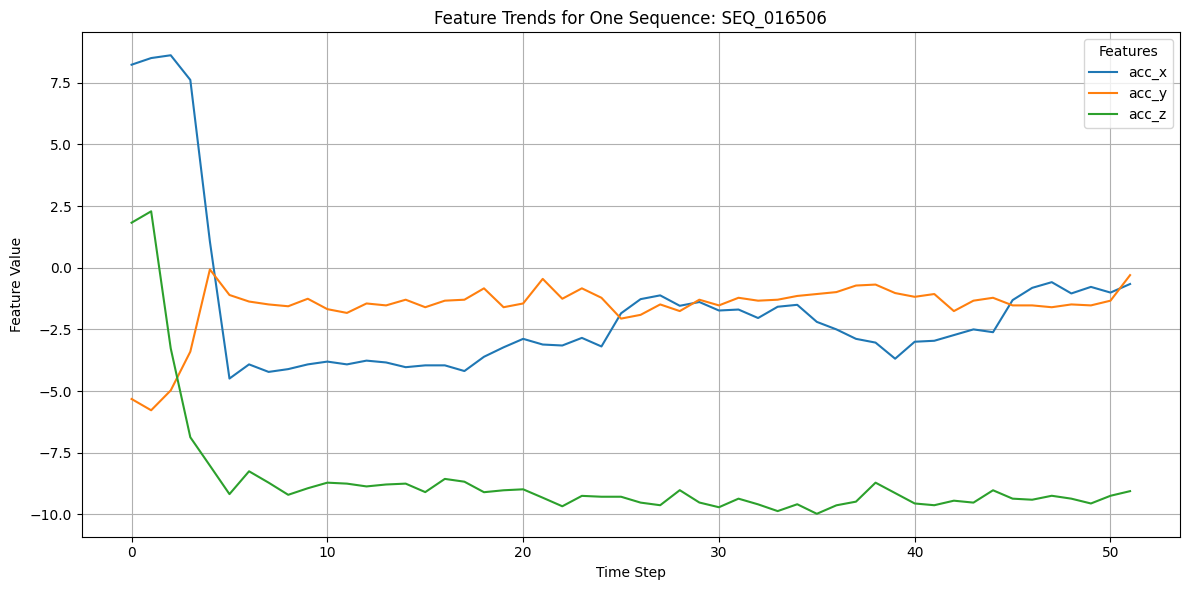

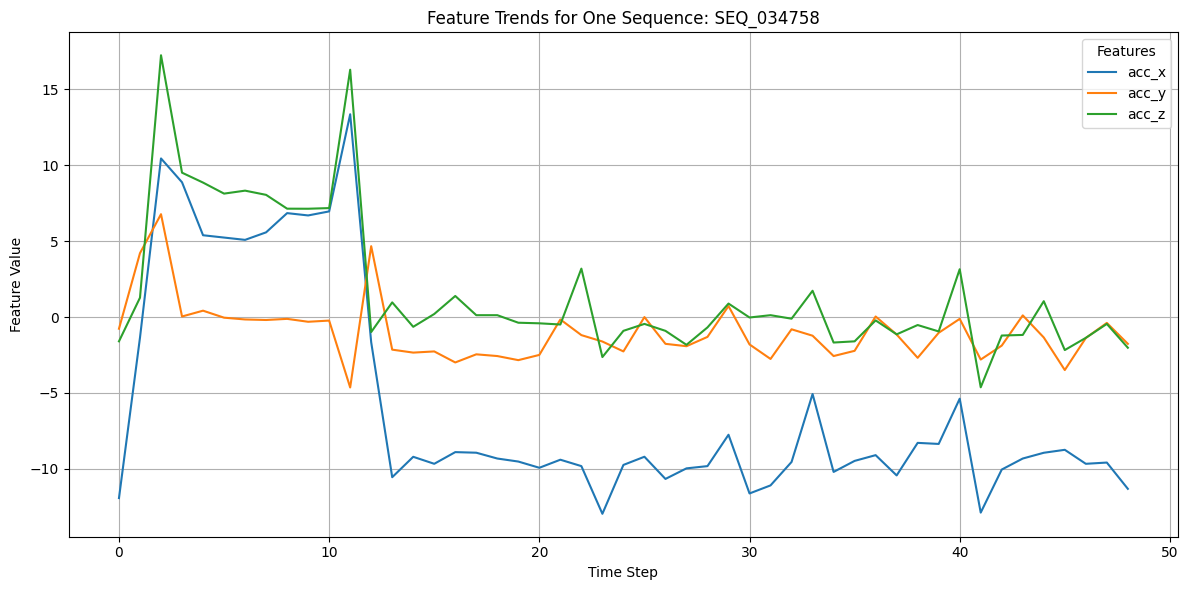

In [ ]:
for id in [
    "SEQ_057296", "SEQ_064191", "SEQ_027115", "SEQ_060532", "SEQ_045465",
    "SEQ_040553", "SEQ_052723", "SEQ_053059", "SEQ_016506", "SEQ_034758"]:
    plot_features_for_sequence(data, id, ['acc_x', 'acc_y', 'acc_z'])

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_features_with_category_highlight(pl_df, seq_id_value, feature_names, category_col,
                                          sequence_id_col='sequence_id', title='Feature Trends with Labels'):
    """
    Plots multiple features for a specific sequence ID and highlights regions based on a categorical column.

    Parameters:
    - pl_df: Polars DataFrame
    - seq_id_value: the value of the sequence ID to filter on
    - feature_names: list of feature columns to plot
    - category_col: name of the categorical column (e.g., 'label')
    - sequence_id_col: column name containing sequence ID
    - title: title of the plot
    """
    # Filter and convert
    df_seq = (
        pl_df
        .filter(pl.col(sequence_id_col) == seq_id_value)
        .select(feature_names + [category_col])
        .to_pandas()
    )

    # Time step index
    time = range(len(df_seq))

    # Plot features
    plt.figure(figsize=(14, 6))
    for feature in feature_names:
        plt.plot(time, df_seq[feature], label=feature)

    # Shade regions by category
    current_label = None
    start_idx = 0
    for i in range(len(df_seq)):
        label = df_seq[category_col].iloc[i]
        if label != current_label:
            if current_label is not None:
                plt.axvspan(start_idx, i, alpha=0.2, color=label_colors.get(current_label, 'gray'))
            current_label = label
            start_idx = i
    # Add final segment
    if current_label is not None:
        plt.axvspan(start_idx, len(df_seq), alpha=0.2, color=label_colors.get(current_label, 'gray'))

    # Legend and labels
    plt.title(f"{title}: {seq_id_value}")
    plt.xlabel("Time Step")
    plt.ylabel("Feature Value")
    plt.legend(title="Features")

    # Add color legend for background labels
    category_values = df_seq[category_col].unique()
    patches = [mpatches.Patch(color=label_colors.get(cat, 'gray'), label=cat) for cat in category_values]
    #plt.legend(handles=patches + plt.gca().get_legend().legendHandles, loc='upper right')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define colors per category (customize as needed)
label_colors = {
    'BFRB': 'lightcoral',
    'Non-BFRB': 'lightgreen',
    'Unknown': 'lightgray',
    "Performs gesture": 'lightgreen',
    "Moves hand to target location": 'lightcoral',
    "Relaxes and moves hand to target location": 'lightblue',
    "Hand at target location": 'yellow'
}


In [ ]:
for id in [
    "SEQ_057296", "SEQ_064191", "SEQ_027115", "SEQ_060532", "SEQ_045465",
    "SEQ_040553", "SEQ_052723", "SEQ_053059", "SEQ_016506", "SEQ_034758"]:
    plot_features_with_category_highlight(data, id, ['acc_x', 'acc_y', 'acc_z'], 'behavior')
    plot_features_with_category_highlight(data, id, ['rot_w','rot_x','rot_y','rot_z'], 'behavior')
    plot_features_with_category_highlight(data, id, ['thm_1','thm_2', 'thm_3', 'thm_4', 'thm_5'], 'behavior')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for id in [
    "SEQ_057296", "SEQ_064191", "SEQ_027115", "SEQ_060532", "SEQ_045465",
    "SEQ_040553", "SEQ_052723", "SEQ_053059", "SEQ_016506", "SEQ_034758"]:
    plot_features_with_category_highlight(data, id, ['acc_x', 'acc_y', 'acc_z','rot_w',
 'rot_x',
 'rot_y',
 'rot_z',
 'thm_1',
 'thm_2',
 'thm_3',
 'thm_4',
 'thm_5'], 'behavior')

In [ ]:
for a in data['behavior'].unique():
  print(a)


Hand at target location
Performs gesture
Relaxes and moves hand to target location
Moves hand to target location


In [ ]:
data.columns

['row_id',
 'sequence_type',
 'sequence_id',
 'sequence_counter',
 'subject',
 'orientation',
 'behavior',
 'phase',
 'gesture',
 'acc_x',
 'acc_y',
 'acc_z',
 'rot_w',
 'rot_x',
 'rot_y',
 'rot_z',
 'thm_1',
 'thm_2',
 'thm_3',
 'thm_4',
 'thm_5',
 'tof_1_v0',
 'tof_1_v1',
 'tof_1_v2',
 'tof_1_v3',
 'tof_1_v4',
 'tof_1_v5',
 'tof_1_v6',
 'tof_1_v7',
 'tof_1_v8',
 'tof_1_v9',
 'tof_1_v10',
 'tof_1_v11',
 'tof_1_v12',
 'tof_1_v13',
 'tof_1_v14',
 'tof_1_v15',
 'tof_1_v16',
 'tof_1_v17',
 'tof_1_v18',
 'tof_1_v19',
 'tof_1_v20',
 'tof_1_v21',
 'tof_1_v22',
 'tof_1_v23',
 'tof_1_v24',
 'tof_1_v25',
 'tof_1_v26',
 'tof_1_v27',
 'tof_1_v28',
 'tof_1_v29',
 'tof_1_v30',
 'tof_1_v31',
 'tof_1_v32',
 'tof_1_v33',
 'tof_1_v34',
 'tof_1_v35',
 'tof_1_v36',
 'tof_1_v37',
 'tof_1_v38',
 'tof_1_v39',
 'tof_1_v40',
 'tof_1_v41',
 'tof_1_v42',
 'tof_1_v43',
 'tof_1_v44',
 'tof_1_v45',
 'tof_1_v46',
 'tof_1_v47',
 'tof_1_v48',
 'tof_1_v49',
 'tof_1_v50',
 'tof_1_v51',
 'tof_1_v52',
 'tof_1_v53',
 'tof